# Redes Neurais FC para classificação binária com dados tabulares

# Motivação
Explicar aqui como foi feito seu trabalho anterior com pca e os resultados do artigo


# Bibliotecas

In [66]:
# Basico e plots
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Processamento
import prince
import missingno as msno
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler

# Construcao de modelo
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import models, layers, optimizers, Input
from sklearn.metrics import classification_report, confusion_matrix

# Comandos para o notebook
%matplotlib inline

# Conhecendo algumas informações da base de dados

In [2]:
# Importando o dataset
df = pd.read_csv('dataset.csv')

In [3]:
# Visualizando rapidamente a base de dados
df

,Age,BMI,Glucose,Insulin,HOMA,Leptin,Adiponectin,Resistin,MCP1,Classification
0,48,23.500000,70,2.707,0.467409,8.8071,9.702400,7.99585,417.114,1
1,83,20.690495,92,3.115,0.706897,8.8438,5.429285,4.06405,468.786,1
2,82,23.124670,91,4.498,1.009651,17.9393,22.432040,9.27715,554.697,1
3,68,21.367521,77,3.226,0.612725,9.8827,7.169560,12.76600,928.220,1
4,86,21.111111,92,3.549,0.805386,6.6994,4.819240,10.57635,773.920,1
...,...,...,...,...,...,...,...,...,...,...
111,45,26.850000,92,3.330,0.755688,54.6800,12.100000,10.96000,268.230,2
112,62,26.840000,100,4.530,1.117400,12.4500,21.420000,7.32000,330.160,2
113,65,32.050000,97,5.730,1.370998,61.4800,22.540000,10.33000,314.050,2
114,72,25.590000,82,2.820,0.570392,24.9600,33.750000,3.27000,392.460,2


Podemos verificar que o problema avaliado na introdução é de fato real: **baixa quantidade amostral**. Modelos complexos como redes neurais sofrem bastante para situações como esta. O mais recomendado seria utilizar modelos mais clássicos como Máquinas de Vetores de Suporte, Florestas Aleatórias ou K-NN. 

Ao se trabalhar com bases de dados pequenas diversos artifícios podem ser usados para evitar sobreajuste de modelo:
- Criar amostras sintéticas
- Diminuir a complexidade do conjunto de *features*
- Utilizar modelos mais clássicos como Máquinas de Vetores de Suporte, Florestas Aleatórias ou K-NN que são mais simples e menos "famintos por dados" como as redes neurais.

Como o intuito deste material é fazer uma rede neural para classificação apenas, não irei adentrar tanto no primeiro e terceiro ponto para não perder o foco.

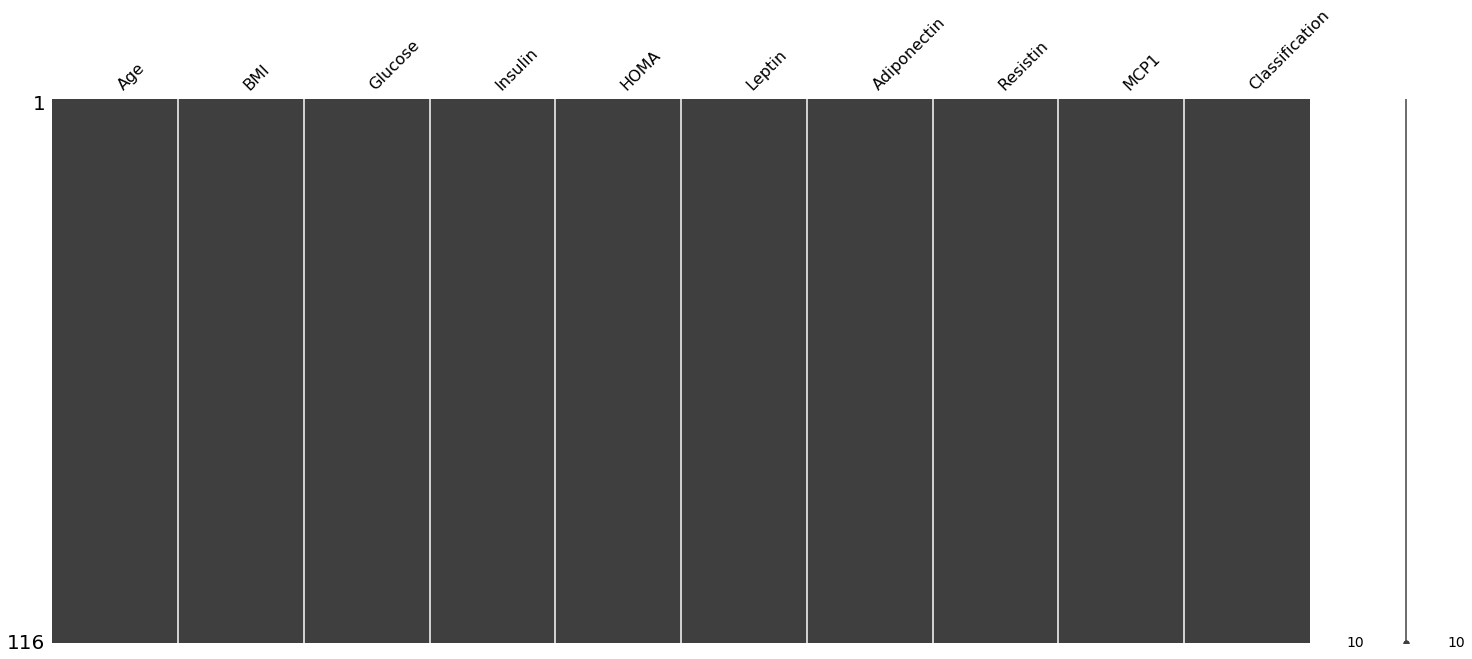

In [4]:
# Verificando a existência de valores faltantes
msno.matrix(df);

Base de dados está completa, logo não teremos que se preocupar com entender os valores faltantes e sua imputação!

In [5]:
# Definindo conjunto de features e variável objetivo
features = df.columns[:-1]
target = df.columns[-1]

In [6]:
# Verificando a distribuição para cada classe
round(100*df[target].value_counts()/len(df), 2)

2    55.17
1    44.83
Name: Classification, dtype: float64

Podemos verificar que as classes estão bem balanceadas!

# Análise Exploratória dos dados
Aqui vamos explorar rapidamente a base de dados para tirar insights para o futuro.

## Construção de mapa de calor para o conjunto de entrada (*features*)

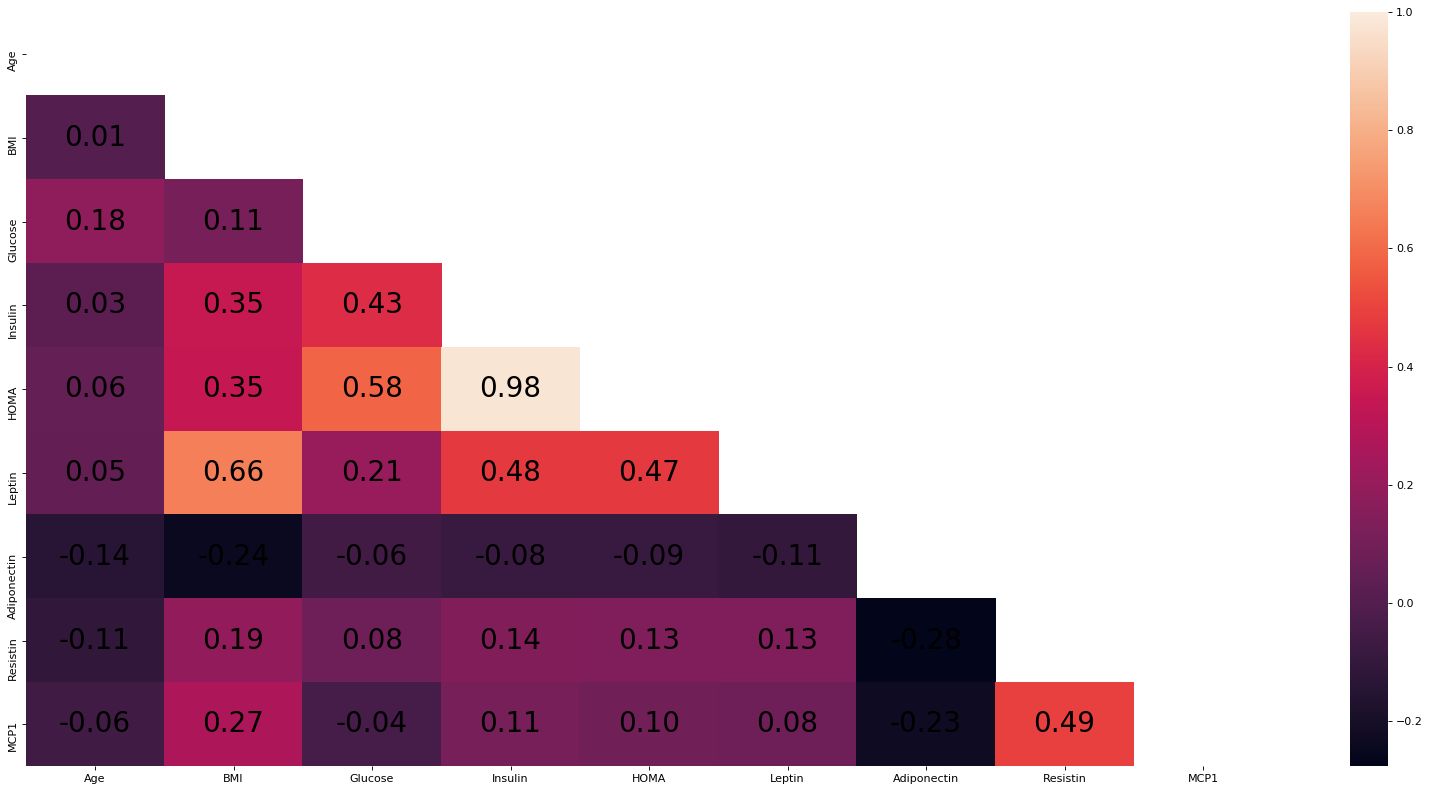

In [7]:
# Calculando a matriz de correlação
corr_matriz = df[features].corr('spearman')

# Plot
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(corr_matriz, annot = True, mask=np.triu(corr_matriz), annot_kws={'fontsize':25, 'color':'black'}, fmt='.2f')
plt.tight_layout()

Podemos verificar uma correlação imensa entre a variável `HOMA` e `Insulin`. Diversos modelos sofrem com variáveis correlacionadas (podem causar uma certa confusão nos modelos e aumentam a complexidade do conjunto de *features* de forma desnecessária). Além delas `Leptin` e `BMI` assim como `Glucose` e `HOMA` demonstram uma correlação intermediária.

Para ficar claro, os níveis de correlação que considero são:
- Acima de 0.80: Forte
- Abaixo de 0.50: Fraca
- Entre esses valores: Intermediária

Mantenha em mente esses conjuntos de variáveis citados, principalmente `HOMA`, pois pelo menos uma será eliminada da análise.

## Distribuição das variáveis particionada pela categoria de classificação

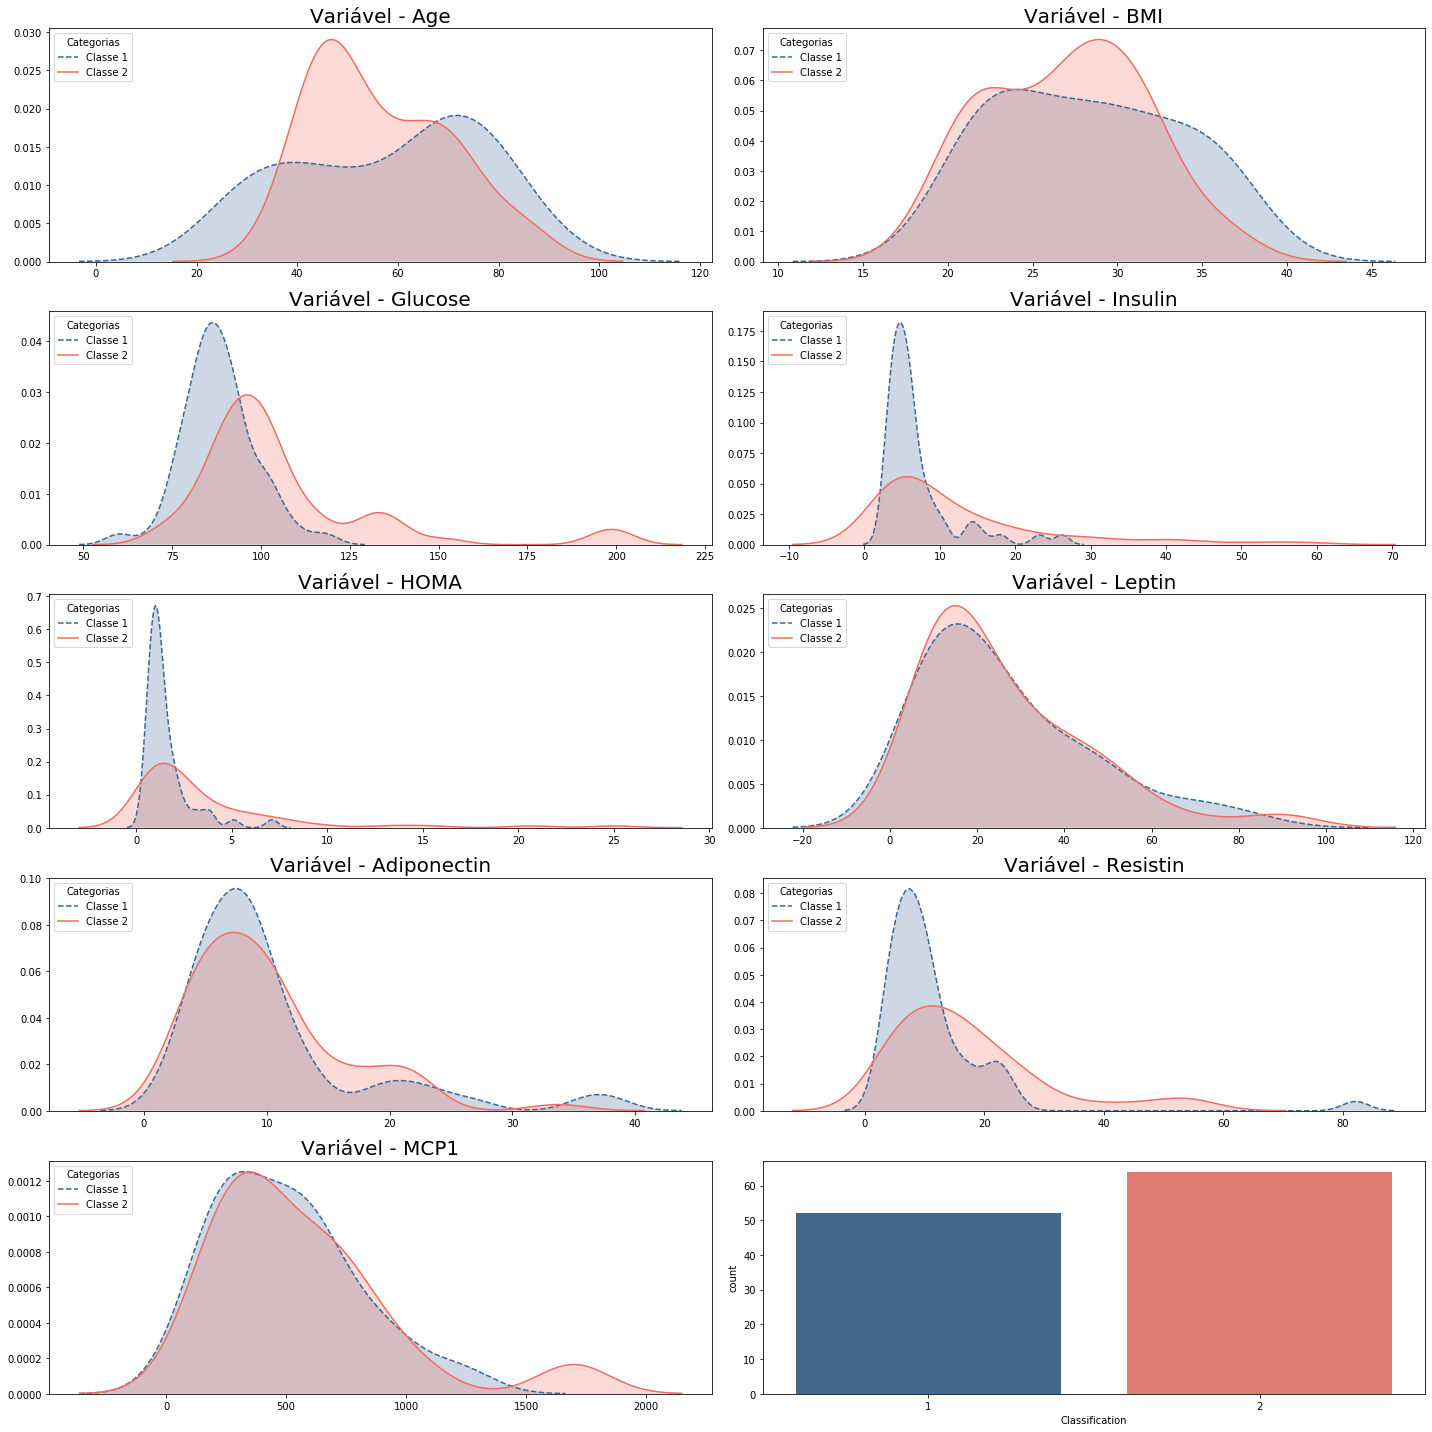

In [8]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(df.loc[df[target]==1, f], shade=True, color='#386796', ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(df.loc[df[target]==2, f], shade=True, color='#F06C61', ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1
        
# Variavel objetivo
sns.countplot(x=target, data=df, palette={1:'#386796',2:'#F06C61'})

# Melhorar a visualizacao final
plt.tight_layout()

Buscava neste gráfico encontrar variáveis que conseguissem separar bem suas amostras de acordo ao conjunto de categorias na saída. A variável `Glucose` é a que mais chega próxima deste objetivo enquanto a variável `Leptin` é a que mais fracassa nesta meta: a distribuição tanto para a categoria 1 quanto para a categoria 2 são praticamente idênticas. Vamos explorar isso mais a frente na próxima seção.

Todavia, um ponto interessante visualizado neste gráfico é: as variáveis `Glucose`,`Resistin`,`HOMA` e `Insulin` demonstraram picos para uma faixa de valores em relação a categoria 1. Esta alta densidade pode ser uma característica interessante que o modelo pode extrair para definir o tipo de categoria para classificação.

## Diagrama de caixas para as variáveis de entrada
Vamos visualizar um pouco mais sobre a distribuição dessas variáveis, verificar se existem muitos valores aberrantes também.

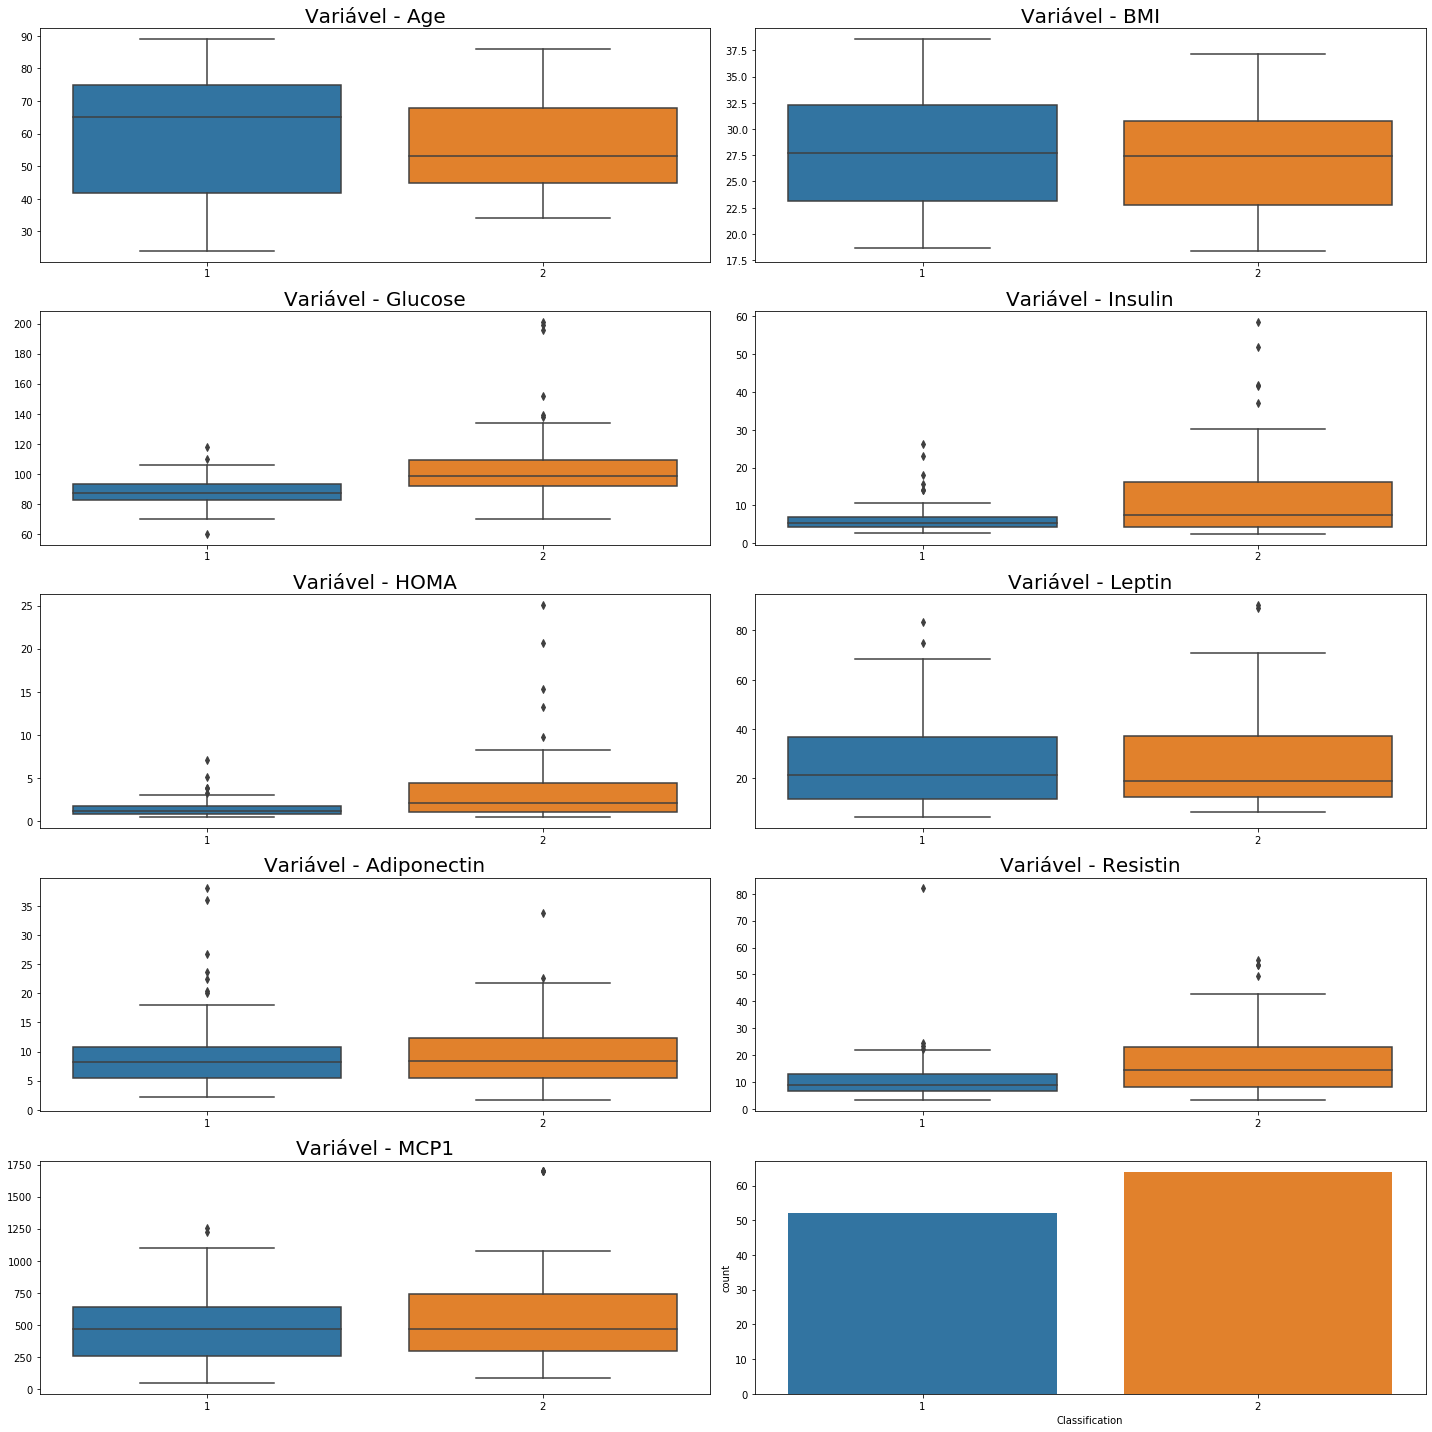

In [9]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.boxplot(x=target, y=f, data=df, ax=axes[r][c])
    # Configuracoes do plot
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    axes[r][c].set_ylabel('')
    axes[r][c].set_xlabel('')
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1
        
# Variavel objetivo
sns.countplot(x=target, data=df)

# Melhorar a visualizacao final
plt.tight_layout()

No geral, verificamos uma presença de valores aberrantes em todas as variáveis com exceção `Age` e `BMI`. Além disso, verificamos de forma mais clara um dos resultados verificados na distribuição do conjunto de entradas para `Glucose`,`Resistin`,`HOMA` e `Insulin`: **seus diagramas de caixas para a categoria 1 são achatados em uma faixa de valor**. Esses padrões serão considerados para a seleção do método de processamento dos valores na seção seguinte.

# Pré-processamento
Aqui será feito a divisão treino/teste assim como a transformação do conjunto de entradas para remover os problemas de dimensionalidades das variáveis (enquanto uma varia de 0 a 30 outra varia de 0 a 1700).

## Divisão Treino/Teste

In [10]:
# Divisão Treino/Teste com proporcao 85/15
x_train, x_test, y_train, y_test = tts(df[features], df[target], test_size=0.15, random_state=1206, stratify=df[target])

In [11]:
# Verificando a quantidade de amostras em cada conjunto
print('Tamanho conjunto de treino: ',len(x_train))
print('Tamanho conjunto de teste: ',len(x_test))

Tamanho conjunto de treino:  98
Tamanho conjunto de teste:  18


In [12]:
# Verificando a proporcao da variável objetivo - conjunto treino
round(y_train.value_counts()/len(y_train), 2)

2    0.55
1    0.45
Name: Classification, dtype: float64

In [13]:
# Verificando a proporcao da variável objetivo - conjunto teste
round(y_test.value_counts()/len(y_test), 2)

2    0.56
1    0.44
Name: Classification, dtype: float64

É importante definir a opção `stratify` ao realizar esta divisão para evitar a predominância de uma determinada classe no conjunto de treino ou teste. Assim, tanto o conjunto de treino como o de teste possuem a mesma proporção.

**NOTA**: Agora irei reavaliar todos os gráficos que gerei na seção anterior apenas para o conjunto de treinamento. Note que não tomei nenhuma decisão naquele momento por precaução para evitar o fenômeno chamado *Data Leakage*. Todavia, acredito que se eu quisesse naquele instante remover variáveis altamente correlacionadas eu poderia sem nenhum problema (não o fiz por escolha). De certa forma, as decisões de pré-processamento, seleção de variáveis serão feitas apenas com o conjunto de treino.

## Mapa de calor do conjunto de treino

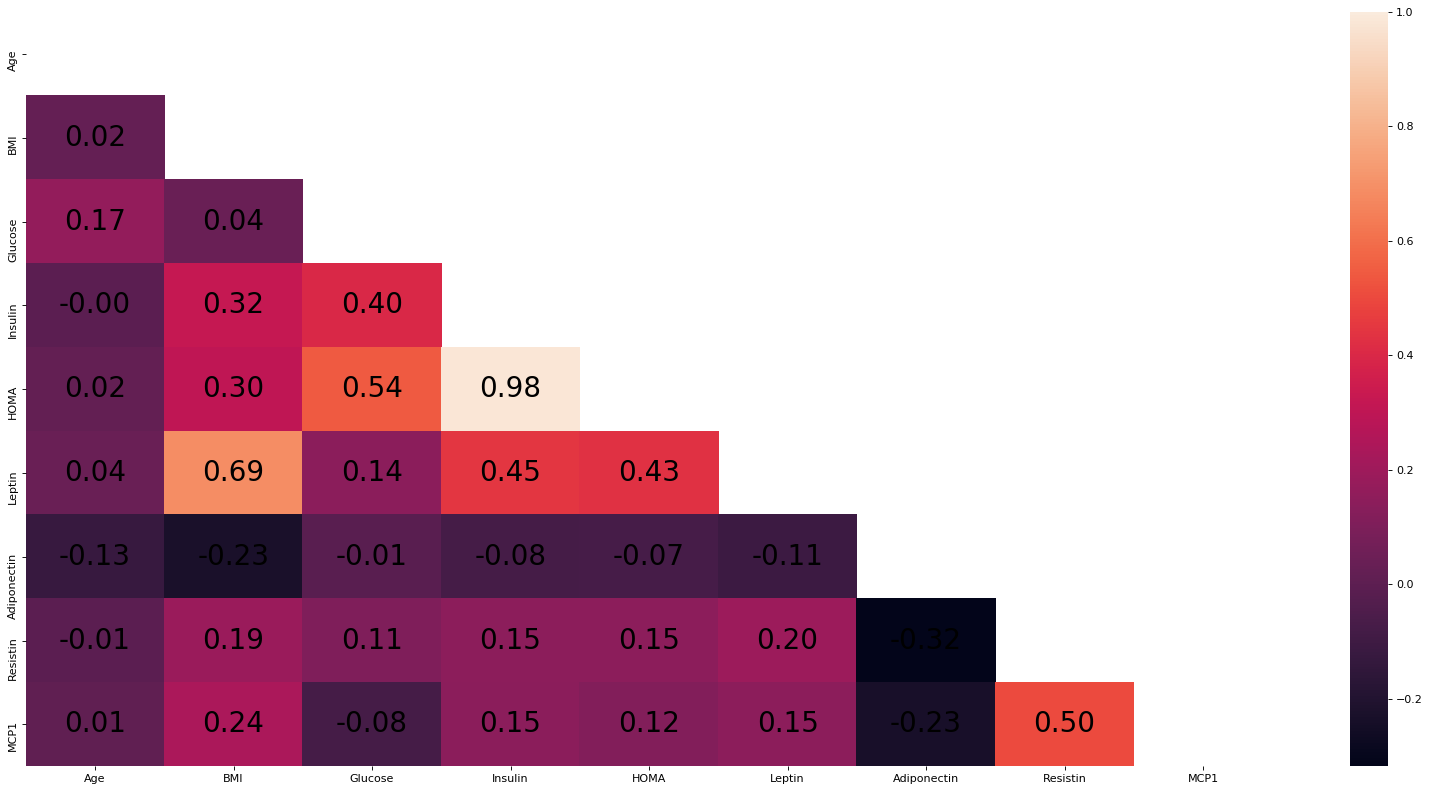

In [14]:
# Calculando a matriz de correlação
corr_matriz = x_train.corr('spearman')

# Plot
plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(corr_matriz, annot = True, mask=np.triu(corr_matriz), annot_kws={'fontsize':25, 'color':'black'}, fmt='.2f')
plt.tight_layout()

Vemos que a correlação `HOMA` e `Insulin` persistem. Note que as outras duas correlações intermediárias que eu havia citado alteraram um pouco.

## Distribuição do conjunto de treino particionado pela categoria de classificação

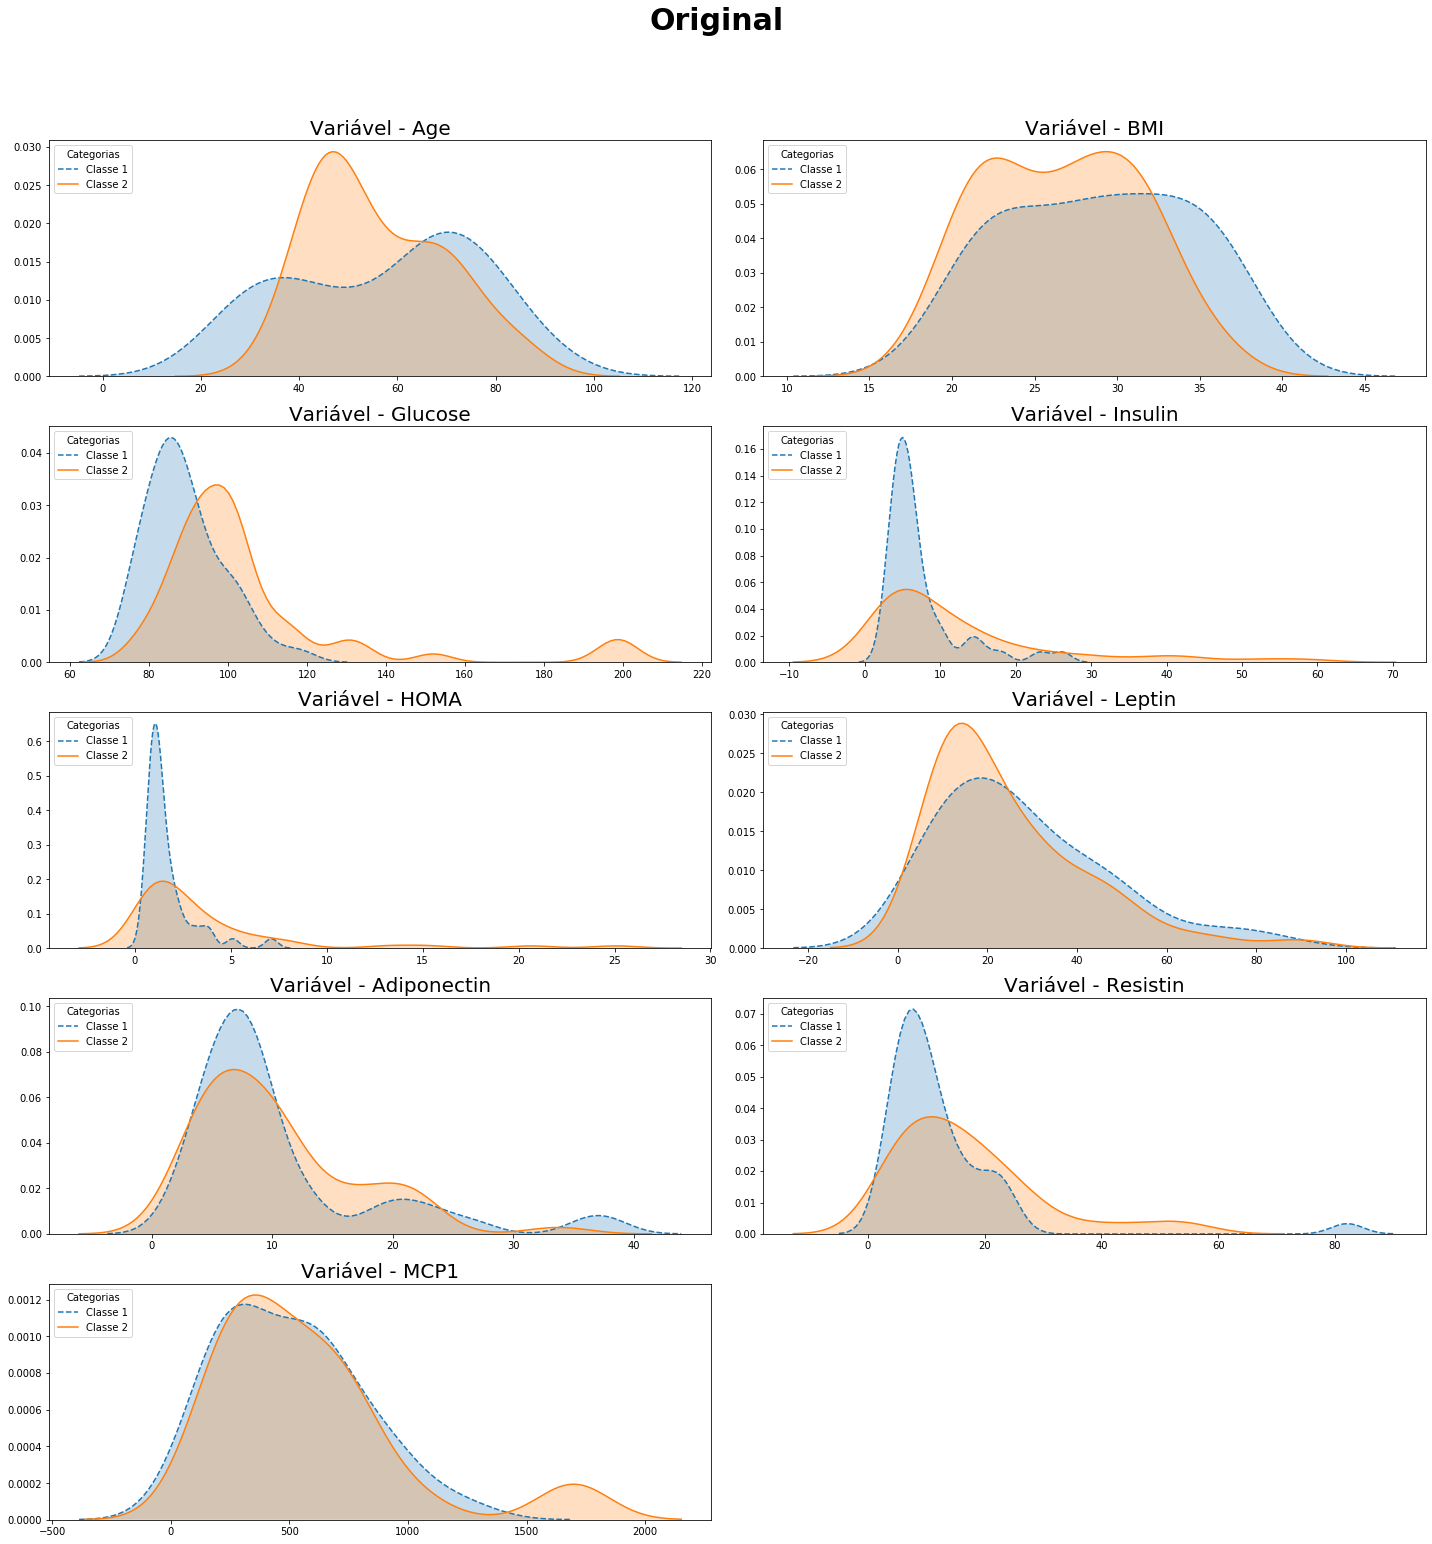

In [15]:
# Definindo a figura
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Original', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(x_train.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(x_train.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/original.png', bbox_inches='tight');

Podemos verificar que `Glucose`,`Resistin`,`HOMA` e `Insulin` demonstram um padrão equivalente ao explorado anteriormente. Isto vale para as outras variáveis. Sendo assim, assumindo uma causa e efeito para evitar repetir o diagrama de caixas, acredito que o diagrama de caixas irá possuir o mesmo padrão.

## Formas de transformação das variáveis
Serão avaliadas 3 formas de transformação de variáveis para encontrar a melhor que se encaixa para este conjunto. Normalmente, o padrão é aplicar uma **padronização (diminuir pela média e dividir pelo desvio padrão)**, porém aqui farei de forma diferente: irei buscar o método capaz de apresentar uma maior separação entre categorias no gráfico de distribuição. A ideia é permitir uma maior facilidade para o modelo conseguir discernir a categoria.

Os três métodos que serão avaliados são:
- Padronização
- Normalização
- Normalização robusta
- Transformação exponencial 

Para cada método irei apresentar a fórmula e discorrer rapidamente sobre o mesmo.

### Método 1 - Padronização

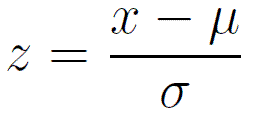

Metodologia padrão para dados tabulares.

In [16]:
# Definir transformador
transformador = StandardScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

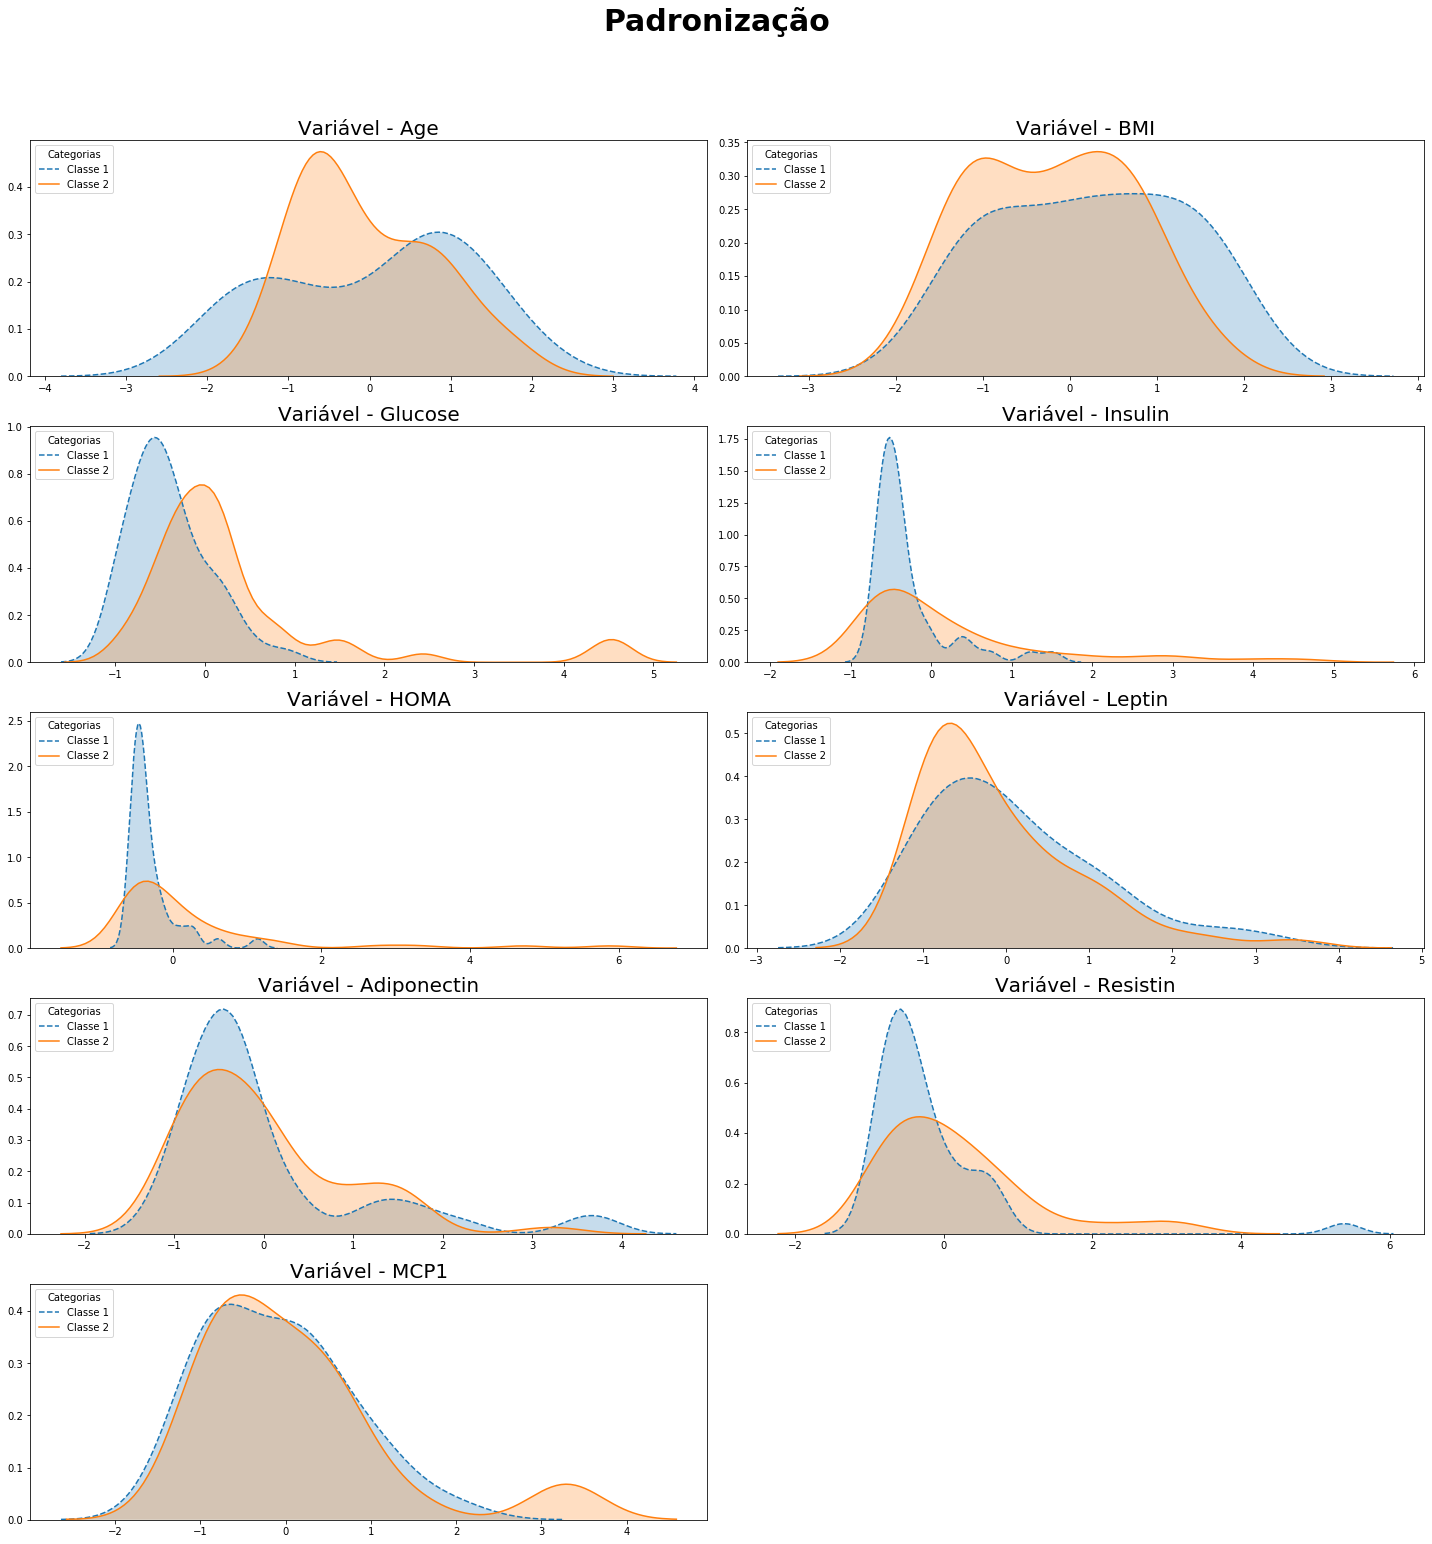

In [17]:
# Verificar distribuicao
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Padronização', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(treino_transf.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(treino_transf.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/padronizacao.png', bbox_inches='tight');

# Deletar objetos criados
del transformador,treino_transf

### Método 2 - Normalização
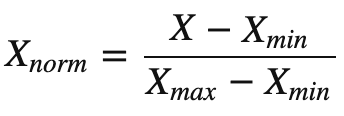

Muito utilizado para tratamento de imagens. Basicamente é utilizado os valores máximo/mínimo da variável para coloca-las em uma mesma faixa. Note que este tipo de transformação não é robusta quando temos valores aberrantes.

In [18]:
# Definir transformador
transformador = MinMaxScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

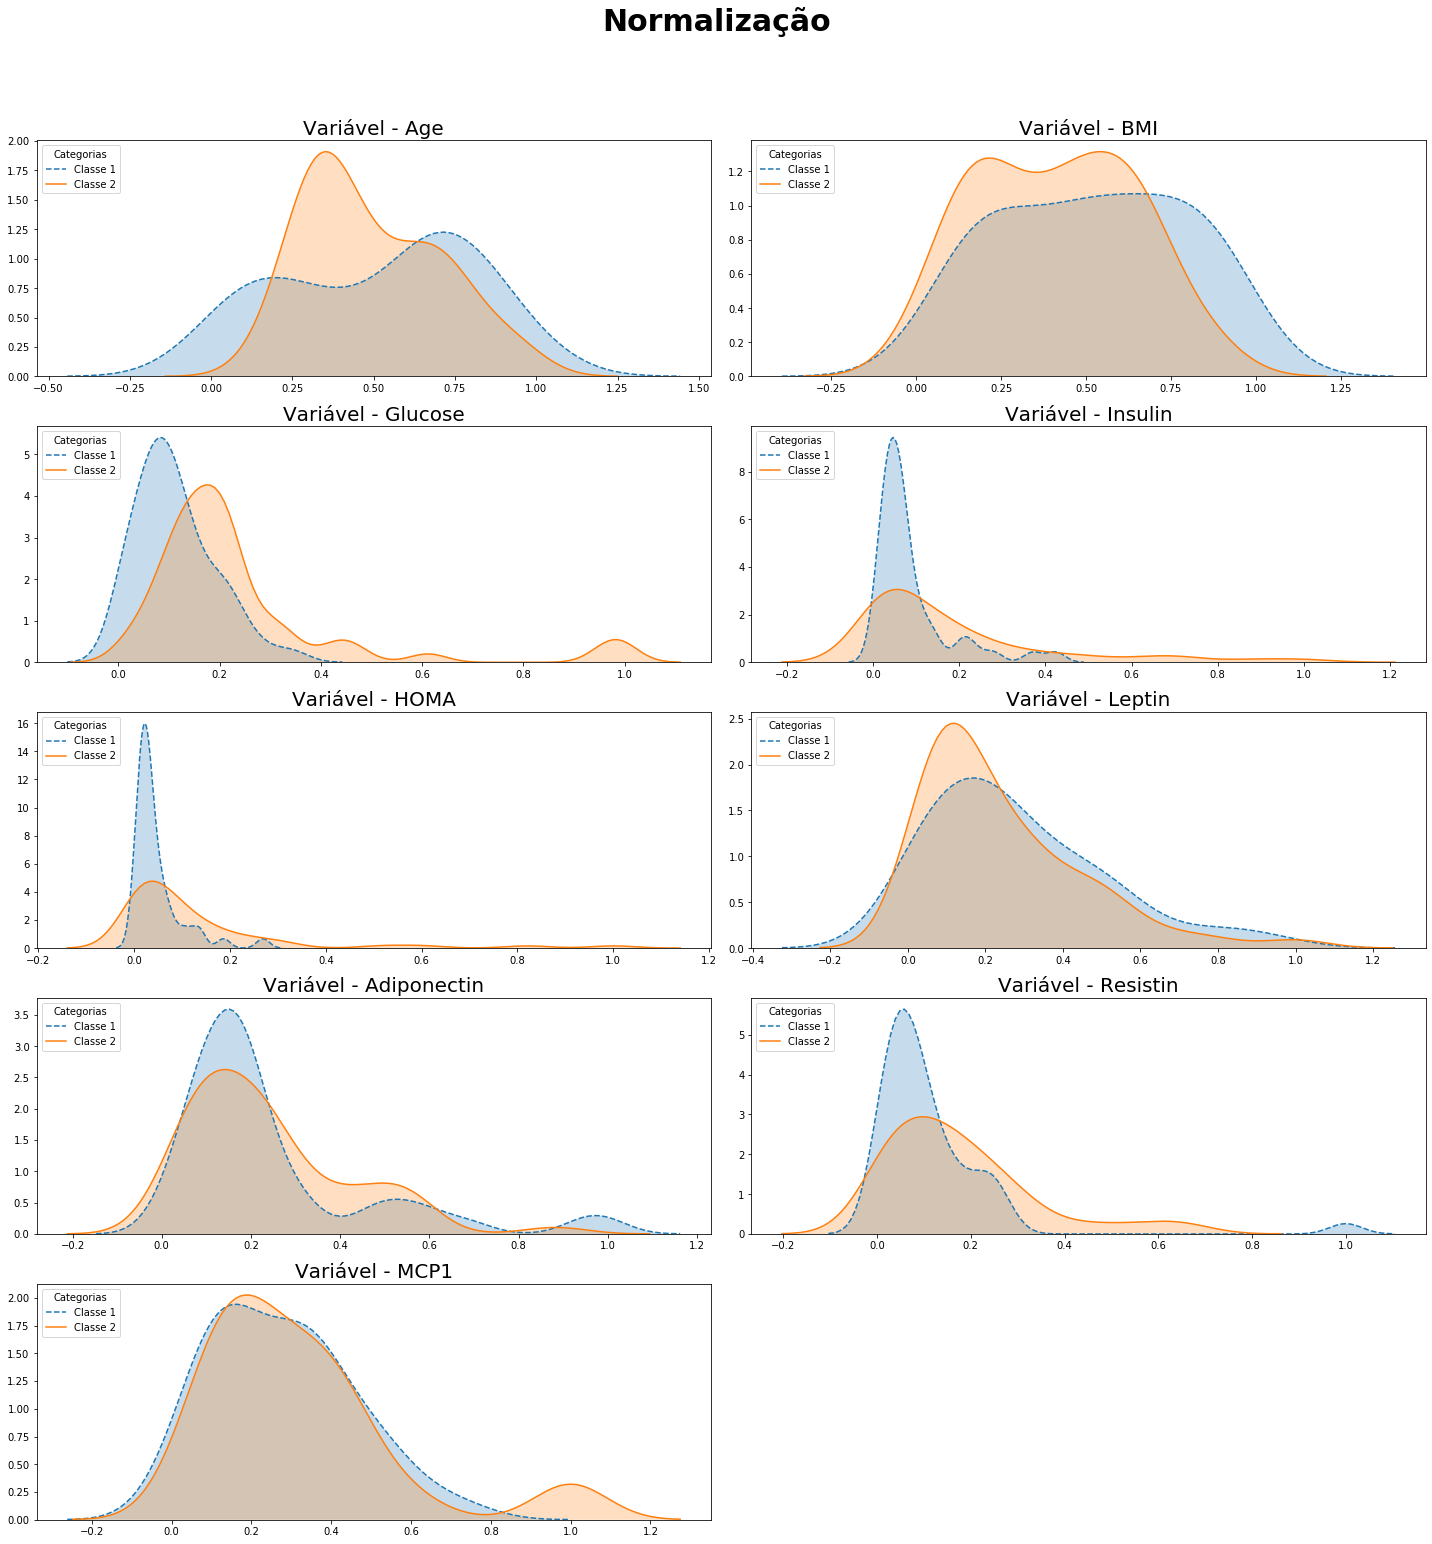

In [19]:
# Verificar distribuicao
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Normalização', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(treino_transf.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(treino_transf.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/normalizacao.png', bbox_inches='tight');

# Deletar objetos criados
del transformador,treino_transf

### Método 3 - Normalização robusta

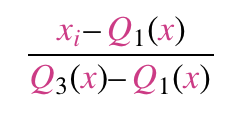

Funciona como a normalização apresentada anteriormente, porém busca reverter o ponto fraco de valores aberrantes usando os quartis:
- Q1 (define o valor para o qual 25% dos valores estão abaixo dele)
- Q3 (define o valor para o qual 75% dos valores estão abaixo dele)

In [20]:
# Definir transformador
transformador = RobustScaler()
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

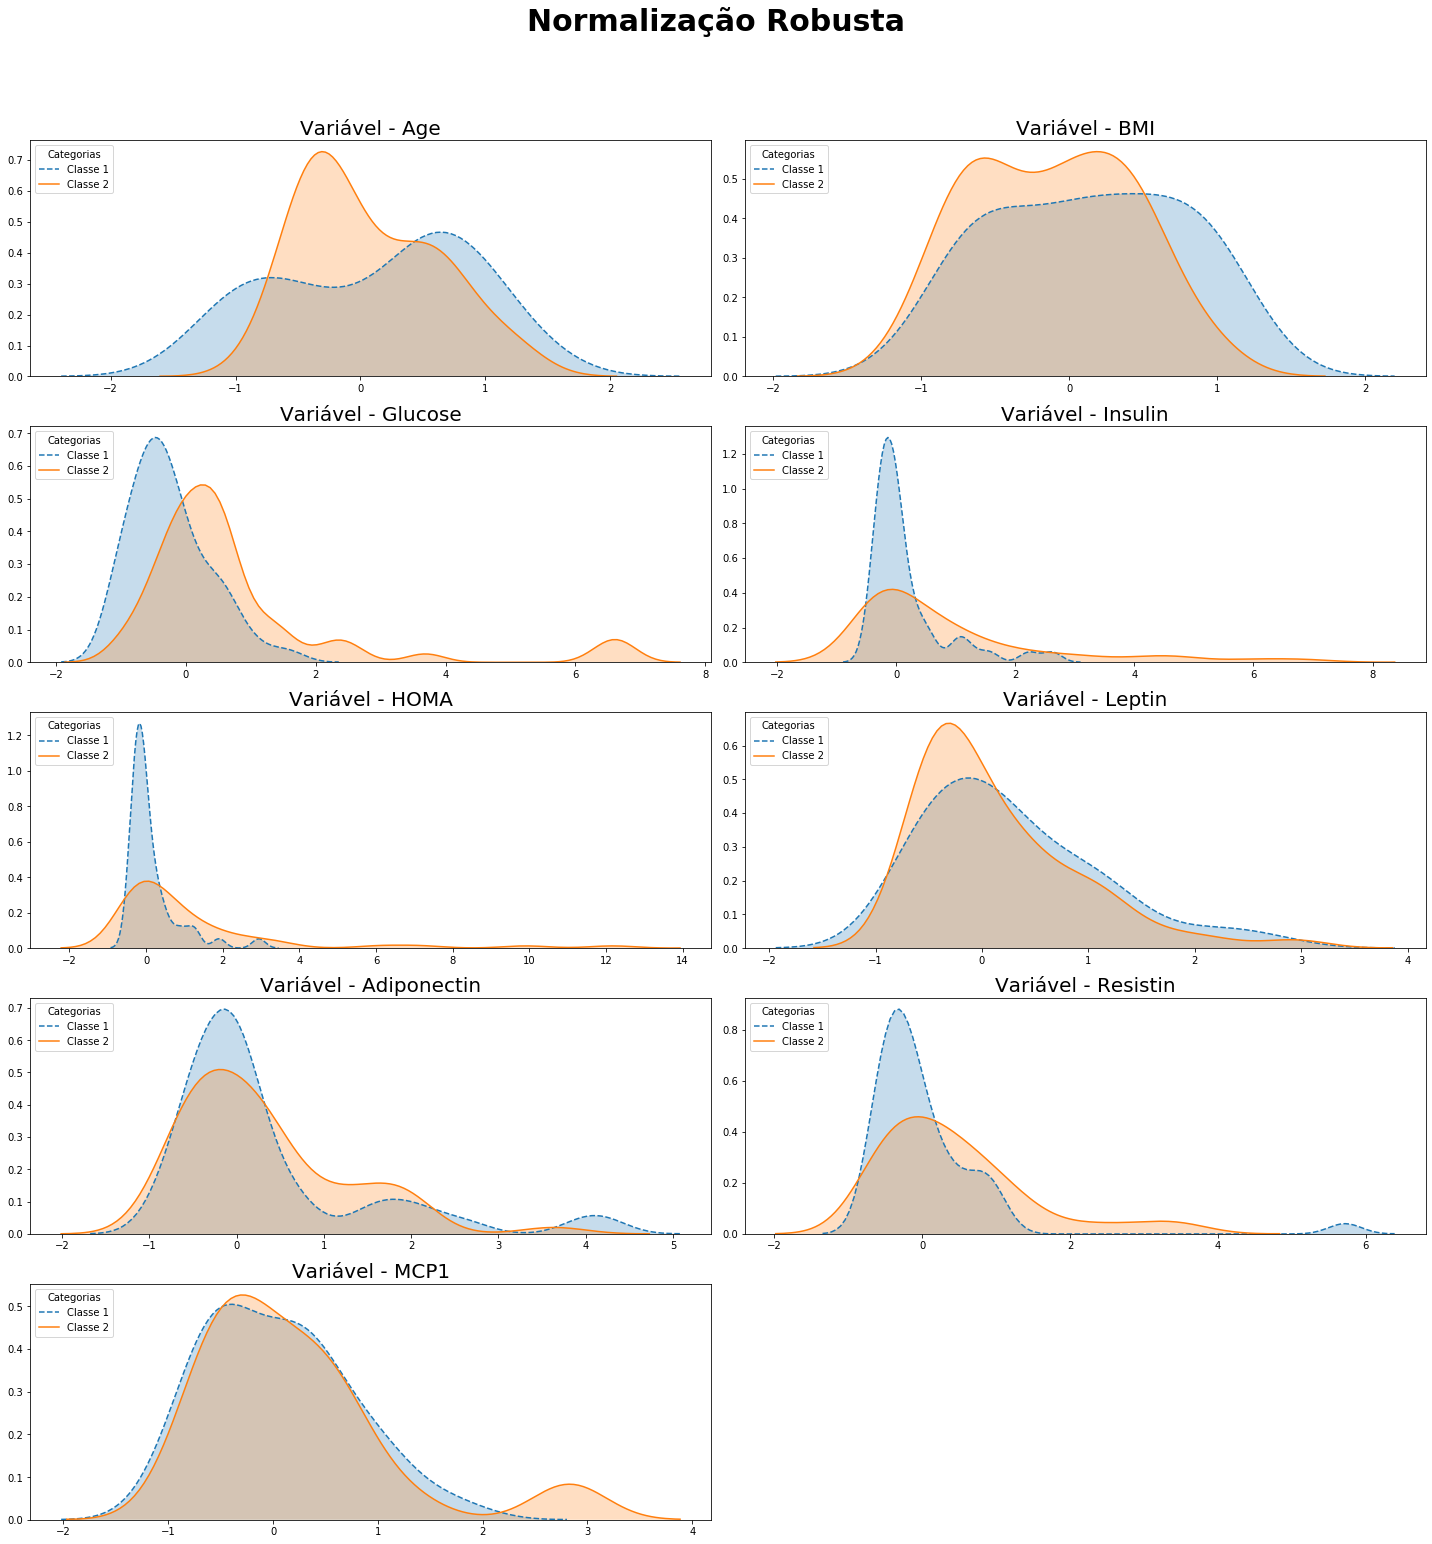

In [21]:
# Verificar distribuicao
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Normalização Robusta', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(treino_transf.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(treino_transf.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/normalizacaoRobusta.png', bbox_inches='tight');

# Deletar objetos criados
del transformador,treino_transf

### Método 4 - Transformação Exponencial
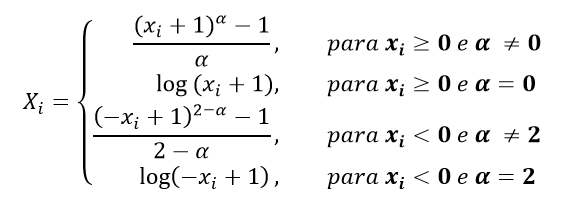

Esta transformação exponencial Yeo-Johnson se trata de uma extensão da transformação Box-Cox para aceitar valores negativos.

In [22]:
# Definir transformador
transformador = PowerTransformer(method='yeo-johnson')
# Aplicar no conjunto de treino
treino_transf = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns, index=x_train.index)

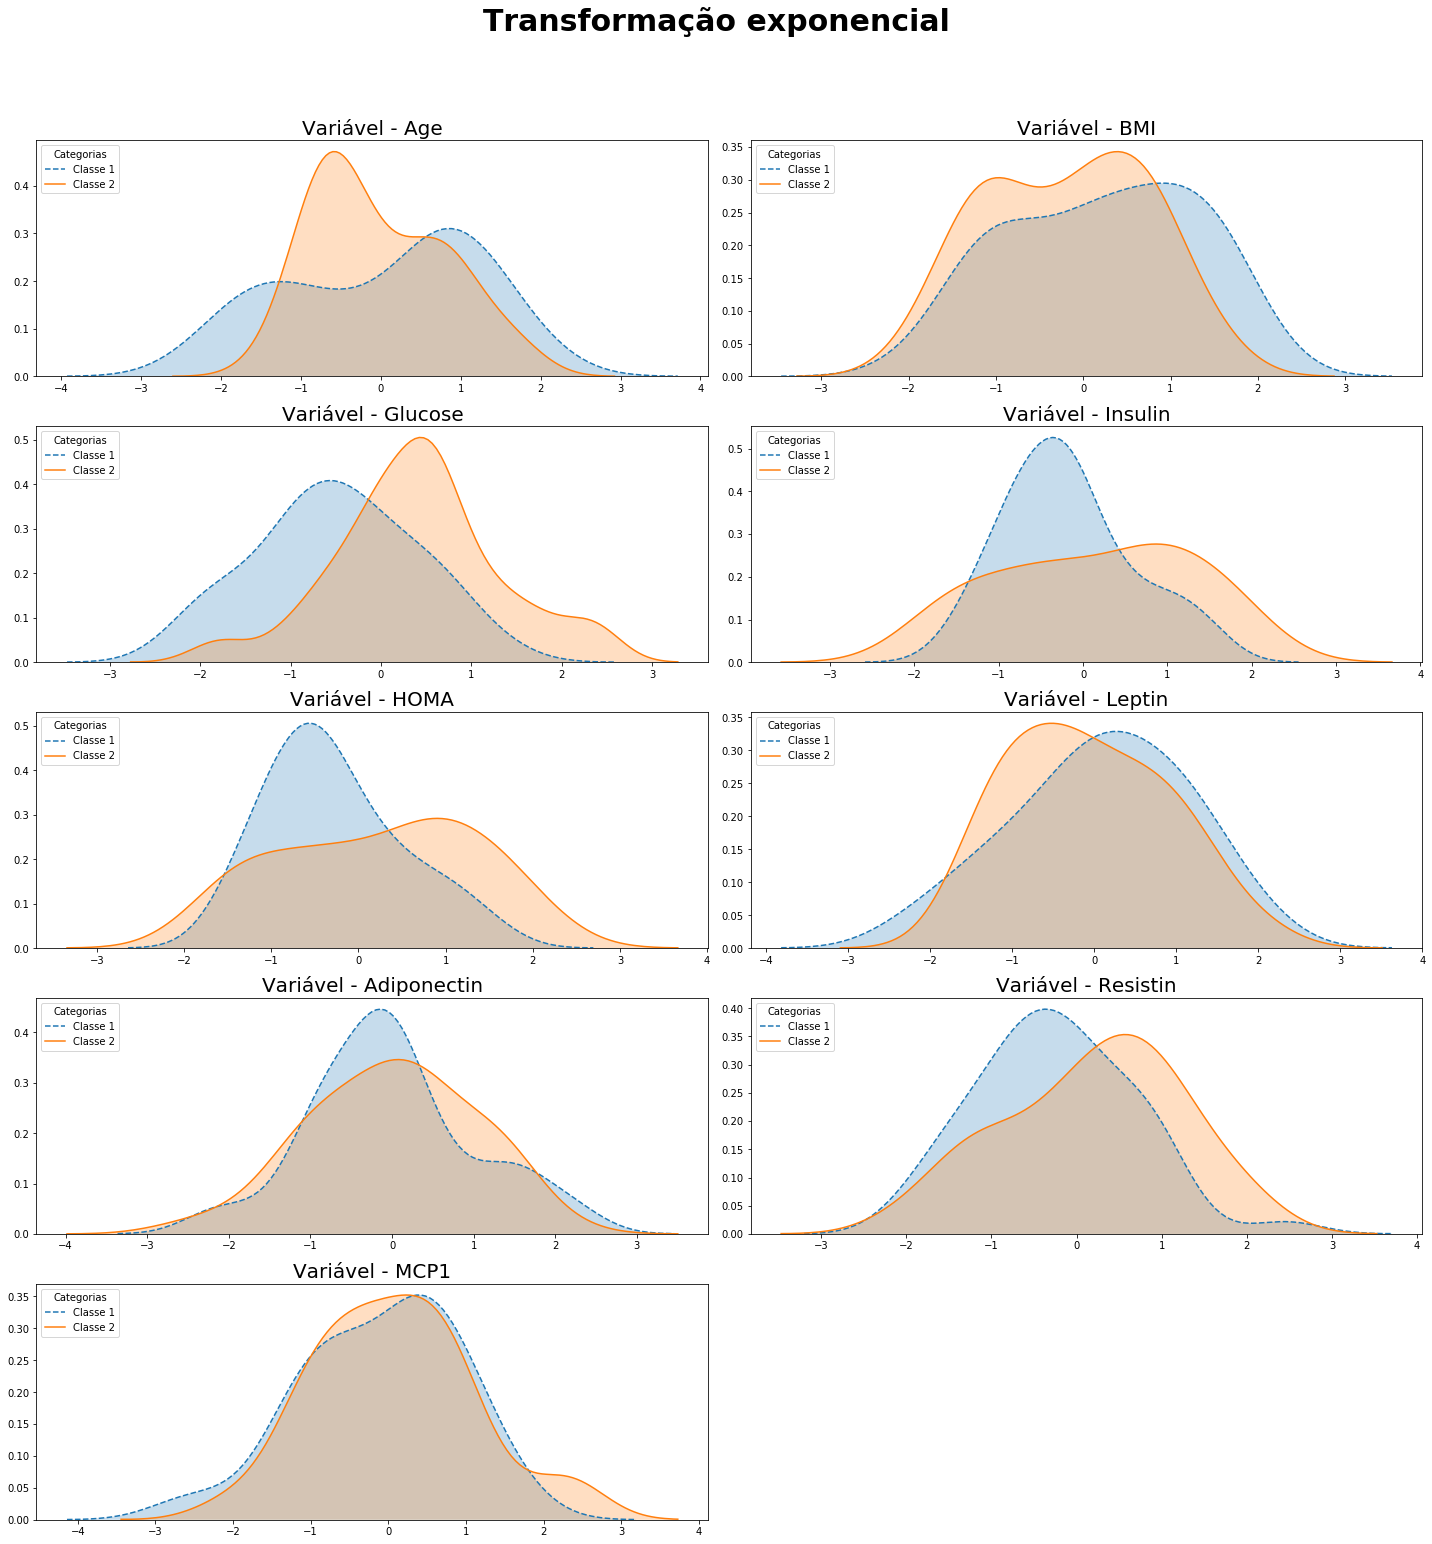

In [23]:
# Verificar distribuicao
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))
r = 0 # indice linha
c = 0 # indice coluna

# Definir um título
fig.suptitle('Transformação exponencial', fontsize=30, fontweight='bold', y=1.07)
# Remover ultimo eixo
fig.delaxes(axes[4][1])

# Conjunto de entradas in Loop
for f in features:
    # Plot distribuição
    sns.kdeplot(treino_transf.loc[y_train==1, f], shade=True, ax=axes[r][c], label='Classe 1', linestyle="--")
    sns.kdeplot(treino_transf.loc[y_train==2, f], shade=True, ax=axes[r][c], label='Classe 2')
    # Configuracoes do plot
    axes[r][c].legend(title='Categorias', loc='upper left')
    axes[r][c].set_title('Variável - ' + f, fontsize=20)
    # Controlar indice do grafico
    c += 1
    if c > 1:
        c = 0
        r += 1

# Melhorar a visualizacao final
plt.tight_layout()

# Salvar imagem para fazer GIF
fig.savefig('figuras/transf_exponencial.png', bbox_inches='tight');

# Deletar objetos criados
del transformador,treino_transf

# Avaliando os resultados para as transformações através de um GIF

![transformacao](https://user-images.githubusercontent.com/32513366/96348966-df1dd800-1082-11eb-9d24-89bef73d5537.gif)

Através de uma rápida visualização gráfica conseguimos perceber que no geral apenas a transformação exponencial mudou a distribuição em comparação com a curva original, os outros métodos demonstraram apenas mudança na escala. Neste momento temos uma decisão:
- Utilizar a **Transformação exponencial**, pois conseguiu em algumas variáveis como `Glucose`, `Resistin` e `Insulin` fazer uma boa separação.
- Utilizar a **Padronização** ou qualquer outra transforamação, pois alterou apenas a escala das variáveis mantendo o formato da distribuição idêntico.

Irei optar pela primeira opção para testar coisas novas! Mas caso você queira testar outro tipo, fique a vontade.

### Aplicar padronização escolhida

In [24]:
# Definir transformador
transformador = PowerTransformer(method='yeo-johnson')
# Aplicar no conjunto de treino
x_train = pd.DataFrame(transformador.fit_transform(x_train), columns=x_train.columns)
# Transformar conjunto de teste
x_test = pd.DataFrame(transformador.transform(x_test), columns=x_train.columns)

### Alterar o conjunto de saída
Ao invés de trabalhar com 1 e 2, vamos trabalhar com 0 e 1 respectivamente.

In [25]:
# Conjunto treino
y_train.replace({1:0, 2:1}, inplace=True)

In [26]:
# Conjunto teste
y_test.replace({1:0, 2:1}, inplace=True)

## Remoção de variáveis
Esta parte fica a critério do leitor. Irei buscar diminuir a quantidade de variáveis removendo `HOMA` dado a alta correlação apenas.

Na construção de modelos irei avaliar outros conjuntos de *features* também, mas por enquanto irei descarta-la da análise.

In [27]:
# Removendo ...
x_train.drop(axis=1, inplace=True, columns=['HOMA'])
x_test.drop(axis=1, inplace=True, columns=['HOMA'])

Agora estamos prontos para construir nosso modelo!

# Construção de modelo: Rede Toda-Conectada (FC)

Trata-se de uma das arquitetura iniciais que surgiram no estudo de *Deep Learning*. Seu modelo consiste em todos os neurônios conectados entre si até o final:
![dnn](https://user-images.githubusercontent.com/32513366/71747029-59ab9d00-2e4d-11ea-91d8-2aa03516f9cd.png)

De forma geral seu parâmetro principal (além da profundidade do modelo, isto é, quantidade de camadas) que precisa ser definido é:
- ```units```: quantidades de neurônios presentes naquela camada

## Definir função para avaliar o treinamento

In [28]:
def avaliando_resultados_graficos(modelo, treinamento, x_train, y_train,x_test, y_test):
    # Plots
    fig, ax = plt.subplots(2,1, figsize=(20,20));
    # Metric X Epochs
    ax[0].plot(treinamento.history['binary_accuracy'], label='Desempenho - Treino')
    ax[0].plot(treinamento.history['val_binary_accuracy'], label = 'Desempenho - Validação')
    ax[0].set_title('Treinamento da Rede - Desempenho', fontsize=25, fontweight='bold')
    ax[0].set_xlabel('Epochs', fontsize=20, fontweight='bold')
    ax[0].set_ylabel('Desempenho', fontsize=20, fontweight='bold')
    ax[0].legend(loc='upper left', fontsize=15)
    # Epoch X Epochs
    ax[1].plot(treinamento.history['loss'], label='Custo - Treino')
    ax[1].plot(treinamento.history['val_loss'], label = 'Custo - Validação')
    ax[1].set_title('Treinamento da Rede - Custo', fontsize=25, fontweight='bold')
    ax[1].set_xlabel('Epochs', fontsize=20, fontweight='bold')
    ax[1].set_ylabel('Custo', fontsize=20, fontweight='bold')
    ax[1].legend(loc='upper right', fontsize=15)
    plt.tight_layout()

## Definir função para gerar arquitetura do modelo

In [49]:
def criar_modelo_FC(dimensao_entrada):
    # Definir modelo
    modelo = models.Sequential()
    # Adicionar entrada
    modelo.add(Input(shape=(dimensao_entrada, ), name='entrada' ))
    
    # Adicionar camadas escondidas
    modelo.add(layers.Dense(units=10, activation='relu'))
    modelo.add(layers.Dense(units=15, activation='relu'))
    modelo.add(layers.Dense(units=30, activation='relu'))
    modelo.add(layers.Dense(units=15, activation='relu'))
    modelo.add(layers.Dense(units=10, activation='relu'))
    
    # Adicionar saida
    modelo.add(layers.Dense(units=1,activation='sigmoid', name='saida'))
    
    # Compilar modelo
    modelo.compile(loss="binary_crossentropy", optimizer='adam', metrics=["binary_accuracy"])
    
    # Retornar
    return modelo

## Construindo o modelo e treinando ...

In [61]:
# Gerar modelo
fc = criar_modelo_FC(dimensao_entrada=x_train.shape[1])
# Treinando a rede
fc_treinamento = fc.fit(x=x_train, y=y_train, epochs=100, validation_split=0.10, verbose=0)

## Analisando os resultados

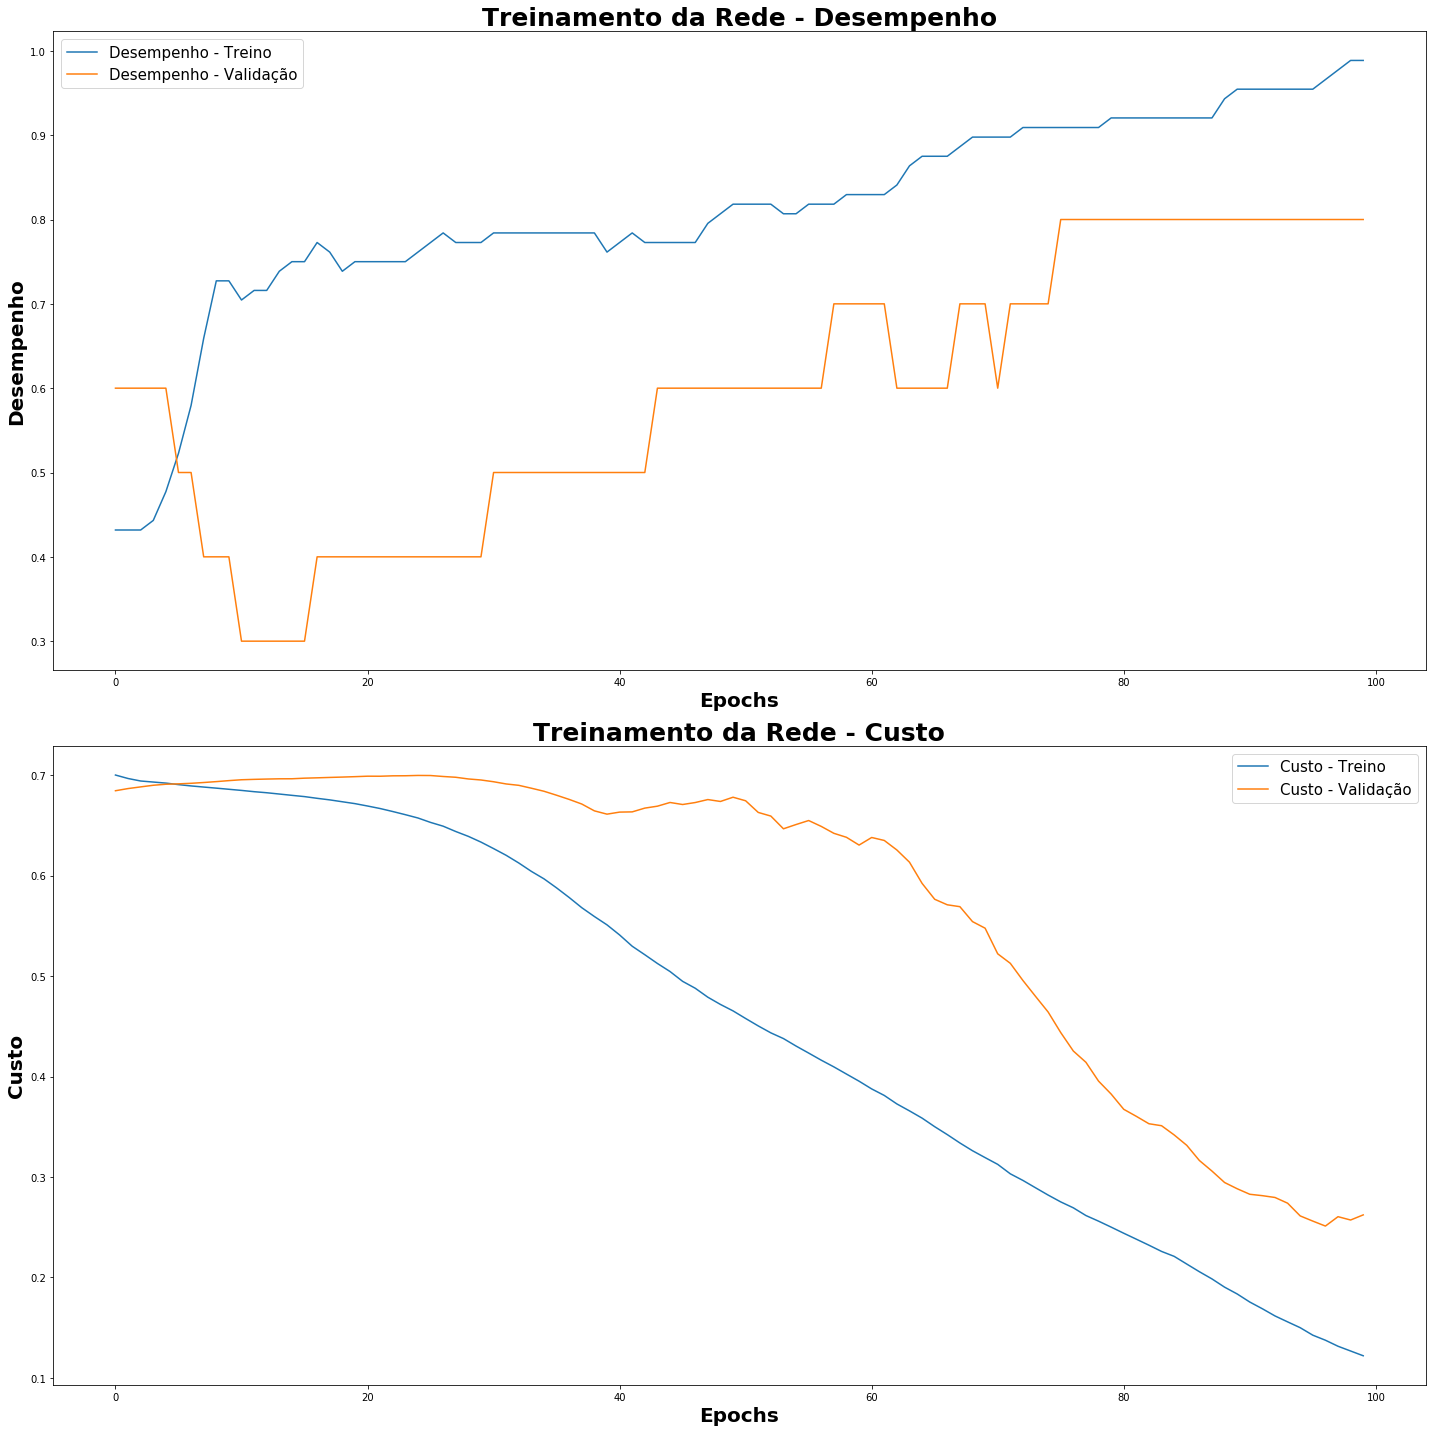

In [62]:
# Verificando resultados para o treinamento
avaliando_resultados_graficos(fc, fc_treinamento, x_train, y_train, x_test, y_test)

Vemos que o treinamento em relação ao custo correu de forma esperada. A grande variação no gráfico de desempenho mostra uma certa instabilidade nos resultados da rede. Isto pode ter ocorrido dado a baixa quantidade amostral.

## Verificando o desempenho no conjunto de teste com a matriz de confusão

In [70]:
# Realizar predição
y_pred = (fc.predict(x_test) > 0.5).astype("int32").reshape(-1,)

In [72]:
# Usando a funcao do sklearn para ter um overview geral do resultado de nosso modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.80      0.80      0.80        10

    accuracy                           0.78        18
   macro avg       0.78      0.78      0.78        18
weighted avg       0.78      0.78      0.78        18



In [74]:
# Matriz de confusao
pd.DataFrame(confusion_matrix(y_test, y_pred, labels=[0, 1]), index=[0, 1], columns=[0, 1])

,0,1
0,6,2
1,2,8


In [77]:
# Confiança do modelo
(fc.predict(x_test)).reshape(-1,).round(2)

array([0.98, 0.59, 0.54, 0.96, 0.71, 0.9 , 0.47, 0.46, 0.77, 0.9 , 0.11,
       0.  , 0.99, 0.03, 0.  , 0.  , 0.96, 0.  ], dtype=float32)

# Explicação de resultados

In [33]:
    # Predict Train
    ax[1][0].plot(y_train, y_train,'bo', markersize=15, label='Ideal');    
    ax[1][0].plot(y_train, model.predict(x_train), 'r+', markersize=15, label='Predito')
    ax[1][0].set_xlabel('Correct Values', fontsize=15, fontweight='bold')
    ax[1][0].set_title('Predicted - Train', fontsize=20, fontweight='bold')
    #ax[1][0].legend(loc='upper right', fontsize=10)
    # Predict Test
    ax[1][1].plot(y_test, y_test,'bo', markersize=15, label='Ideal');    
    ax[1][1].plot(y_test, model.predict(x_test),'r+', markersize=15, label='Predito')
    ax[1][1].set_xlabel('Correct Values', fontsize=15, fontweight='bold')
    ax[1][1].set_title('Predicted - Test', fontsize=20, fontweight='bold')
    #ax[1][1].legend(loc='upper right', fontsize=10)
    # Melhorar plot

NameError: name 'ax' is not defined